In [2]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import cc_acquire
import cc_prepare

In [3]:
df = pd.read_csv('df_exploration_ready_with_ROI.csv',index_col=[0])
# df = df.iloc[: , 1:]
df.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,deg_percent_awarded_history.1,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,3.00,...,0.04,9.00,"16,619.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-67,250.75","76,423.88"


In [204]:
df.shape

(68546, 145)

In [7]:
# cols = ['avg_net_price_program','avg_net_price_other']
# df1 = df.drop(columns = cols)
# df1.shape

(71422, 125)

In [8]:
# df1 = df1.dropna(subset=['city'])
# df1.shape

(68546, 125)

In [9]:
def clean_step1(df):
    cols = ['avg_net_price_program','avg_net_price_other']
    df = df.drop(columns = cols)
    df = df.dropna(subset=['city'])
    return df

In [11]:
# df = clean_step1(df)
# df.shape

(68546, 125)

In [61]:
# missing value status after clean step 1
cc_prepare.nulls_by_col(df).to_csv('missing_value_after_step1.csv')

## start explore!

* Summary Statistics across majors
* Breakdown of demographics by major (location, gender, socioeconomic background, institution control, part-time vs. full-time enrollment, etc.)

* Geographic Specific Questions:
        Are there differences across where a university/college is located and the ROI earnings?
        Continental US
        State
        Cities 
        Postal Code

In [205]:
location = pd.read_csv('location_info_by_state.csv')
location.head()

,state,latitude,longitude
0,AK,63.59,-154.49
1,AL,32.32,-86.90
2,AR,35.20,-91.83
3,AZ,34.05,-111.09
4,CA,36.78,-119.42


In [63]:
df.shape

(68546, 145)

In [206]:
# add lat and lng for states
location = location.rename(columns={"state": "state_post_code"})
df = pd.merge(df, location, how = 'left', on = 'state_post_code')
df.shape

(68546, 147)

In [65]:
df.columns.tolist()

['unit_id_institution',
 'college_name',
 'institution_control',
 'state_post_code',
 'zip_code',
 'city',
 'region_ipeds',
 'title_IV_eligibility',
 'pred_degree',
 'pred_degree_0and4',
 'degree_name',
 'degree_code',
 'major_code',
 'major_name',
 'branch_number',
 'avg_net_price_public',
 'avg_net_price_private',
 'title_IV_student_number',
 'pub_fam_income_0_30000',
 'private_fam_income_0_30000',
 'program_fam_income_0_30000',
 'other_fam_income_0_30000',
 'pub_fam_income_30001_48000',
 'private_fam_income_30001_48000',
 'program_fam_income_30001_48000',
 'other_fam_income_30001_48000',
 'pub_fam_income_48001_75000',
 'private_fam_income_48001_75000',
 'program_fam_income_48001_75000',
 'other_fam_income_48001_75000',
 'pub_fam_income_75001_110000',
 'private_fam_income_75001_110000',
 'program_fam_income_75001_110000',
 'other_fam_income_75001_110000',
 'pub_fam_income_over_110000',
 'private_fam_income_over_110000',
 'program_fam_income_over_110000',
 'other_fam_income_over_11000

In [4]:
def split_data(df): 
    train_and_validate, test = train_test_split(
                                                df, 
                                                test_size = 0.2, 
                                                random_state = 123,
                                                stratify = df["major_category"])

    train, validate = train_test_split(
                                    train_and_validate,
                                    test_size = 0.3,
                                    random_state = 123,
                                    stratify = train_and_validate["major_category"])
    return train, validate, test

In [5]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((38385, 145), (16451, 145), (13710, 145))

In [68]:
cc_prepare.nulls_by_col(train).head()

,num_rows_missing,percent_rows_missing
program_fam_income_over_110000,38385,100.00
program_fam_income_48001_75000,38385,100.00
other_fam_income_30001_48000,38385,100.00
program_fam_income_30001_48000,38385,100.00
other_fam_income_0_30000,38385,100.00


## Major
### 1. How is the majors summary in US?

<AxesSubplot:xlabel='count', ylabel='major_category'>

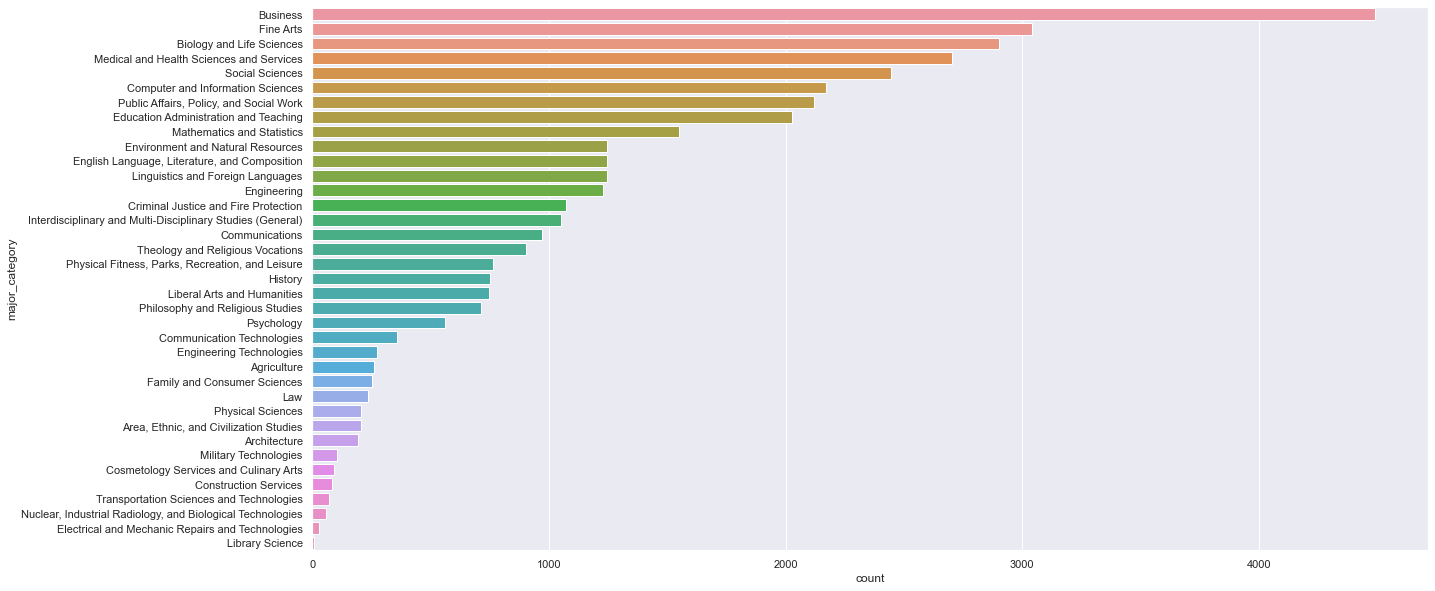

In [69]:
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train, order = train['major_category'].value_counts().index)

In [97]:
train.major_category.value_counts().head(10)

Business                                    4491
Fine Arts                                   3041
Biology and Life Sciences                   2902
Medical and Health Sciences and Services    2702
Social Sciences                             2446
Computer and Information Sciences           2170
Public Affairs, Policy, and Social Work     2120
Education Administration and Teaching       2026
Mathematics and Statistics                  1551
Environment and Natural Resources           1247
Name: major_category, dtype: int64

* Top five majors:
    1. Business
    2. Fine Arts                     
    3. Biology and Life Sciences                
    4. Medical and Health Sciences and Services   
    5. Social Sciences      
    6. Computer and Information Sciences      
    7. Public Affairs, Policy, and Social Work  
    8. Education Administration and Teaching   
    9. Mathematics and Statistics     
    10. Environment and Natural Resources    

### college type summary

In [98]:
train.institution_control.value_counts()

Private, nonprofit     20718
Public                 16359
Private, for-profit     1308
Name: institution_control, dtype: int64

In [100]:
a =20817
b =16359
c =1308
d = a+b+c

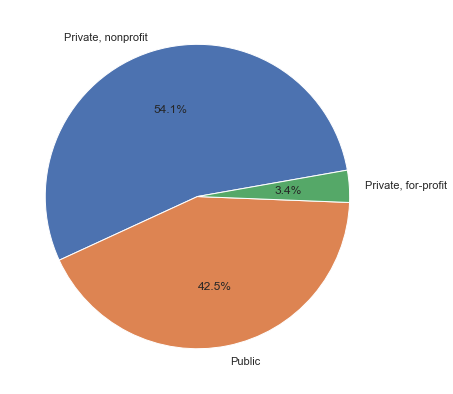

In [101]:
plt.figure(figsize=(7,7))
y = np.array([a/d, b/d, c/d])
mylabels = ["Private, nonprofit", "Public", "Private, for-profit"]

plt.pie(y, labels = mylabels, autopct='%1.1f%%', startangle = 10)
plt.show() 

### 2. Major summary in different school type

<AxesSubplot:xlabel='count', ylabel='major_category'>

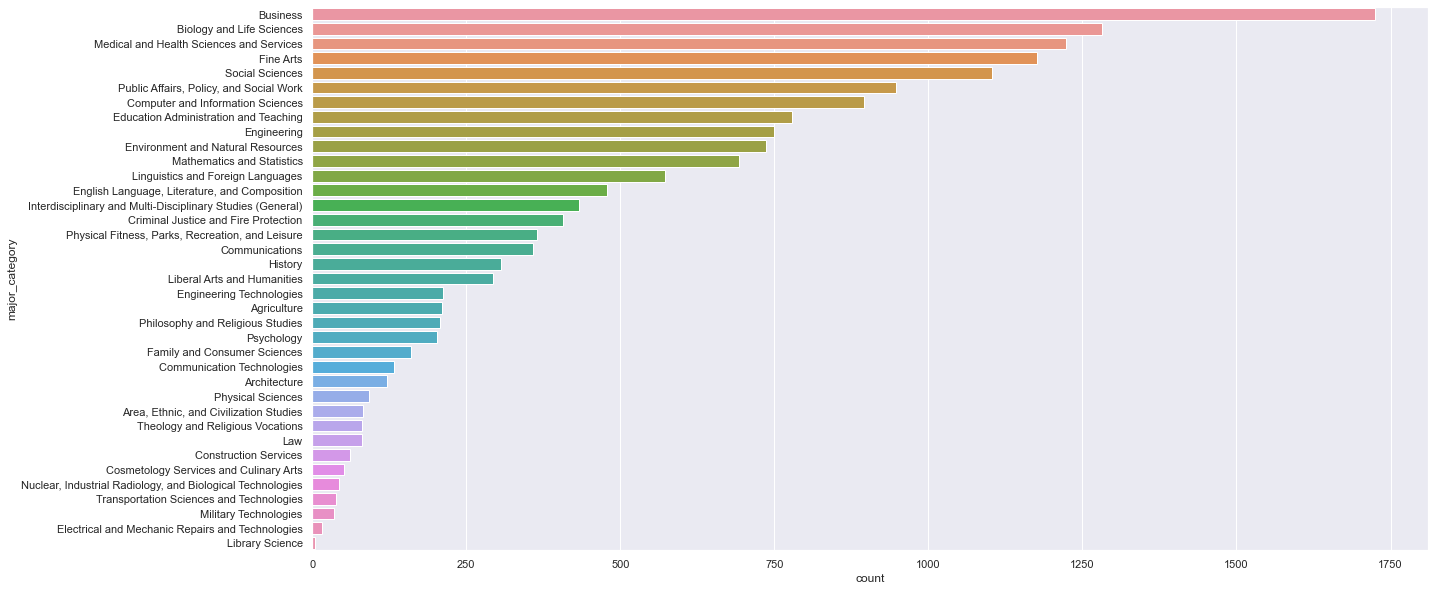

In [94]:
# public
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train[train.institution_control == 'Public'],
              order = train[train.institution_control == 'Public']['major_category'].value_counts().index)

In [102]:
train[train.institution_control == 'Public'].major_category.value_counts().head()

Business                                    1725
Biology and Life Sciences                   1281
Medical and Health Sciences and Services    1223
Fine Arts                                   1177
Social Sciences                             1104
Name: major_category, dtype: int64

<AxesSubplot:xlabel='count', ylabel='major_category'>

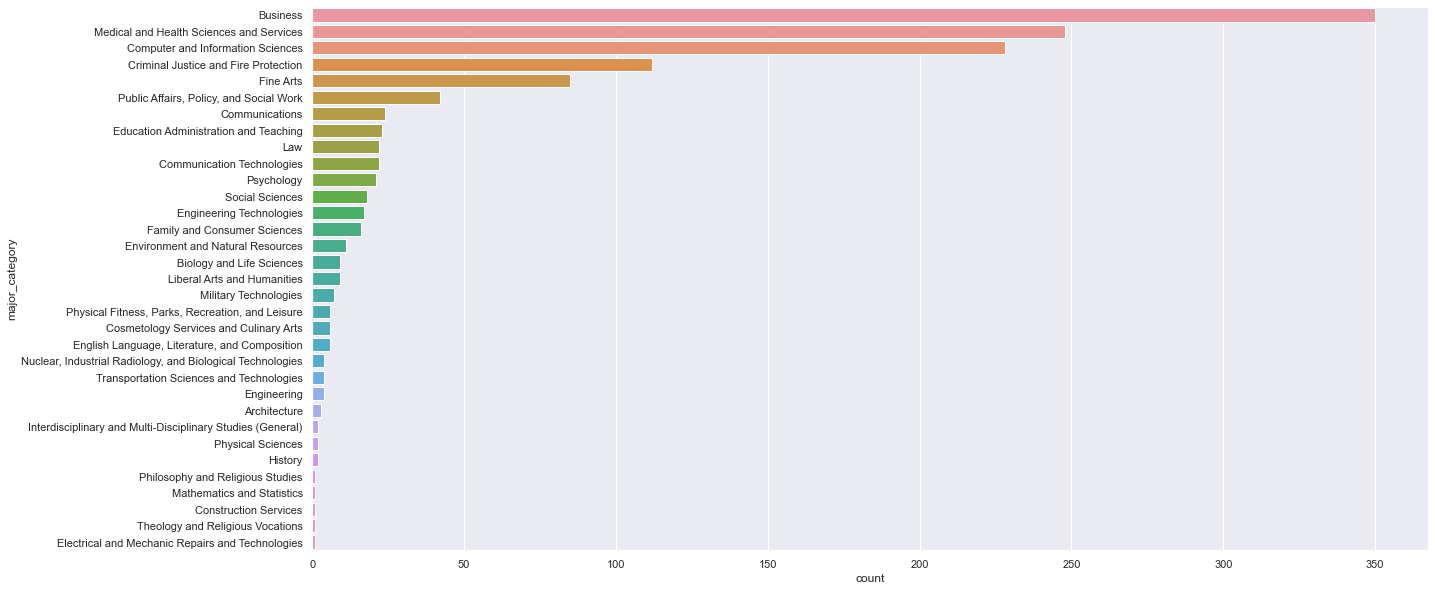

In [96]:
# Private, for-profit
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train[train.institution_control == 'Private, for-profit'],
              order = train[train.institution_control == 'Private, for-profit']['major_category'].value_counts().index)

In [104]:
train[train.institution_control == 'Private, for-profit'].major_category.value_counts().head()

Business                                    350
Medical and Health Sciences and Services    248
Computer and Information Sciences           228
Criminal Justice and Fire Protection        112
Fine Arts                                    85
Name: major_category, dtype: int64

<AxesSubplot:xlabel='count', ylabel='major_category'>

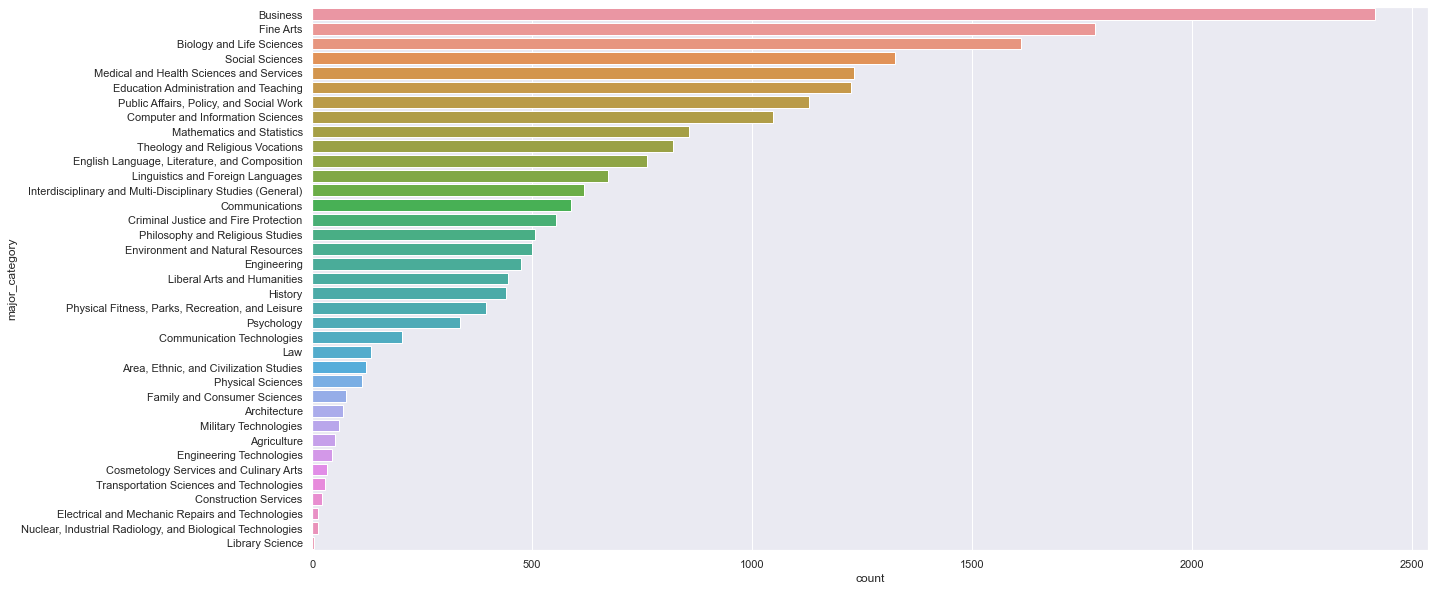

In [103]:
# Private, nonprofit
plt.figure(figsize=(20,10))
sns.countplot(y='major_category', data=train[train.institution_control == 'Private, nonprofit'],
              order = train[train.institution_control == 'Private, nonprofit']['major_category'].value_counts().index)

In [105]:
train[train.institution_control == 'Private, nonprofit'].major_category.value_counts().head()

Business                                    2416
Fine Arts                                   1779
Biology and Life Sciences                   1612
Social Sciences                             1324
Medical and Health Sciences and Services    1231
Name: major_category, dtype: int64

### 3. 5-year and 10-year ROL across majors.

<AxesSubplot:xlabel='roi_5yr', ylabel='major_category'>

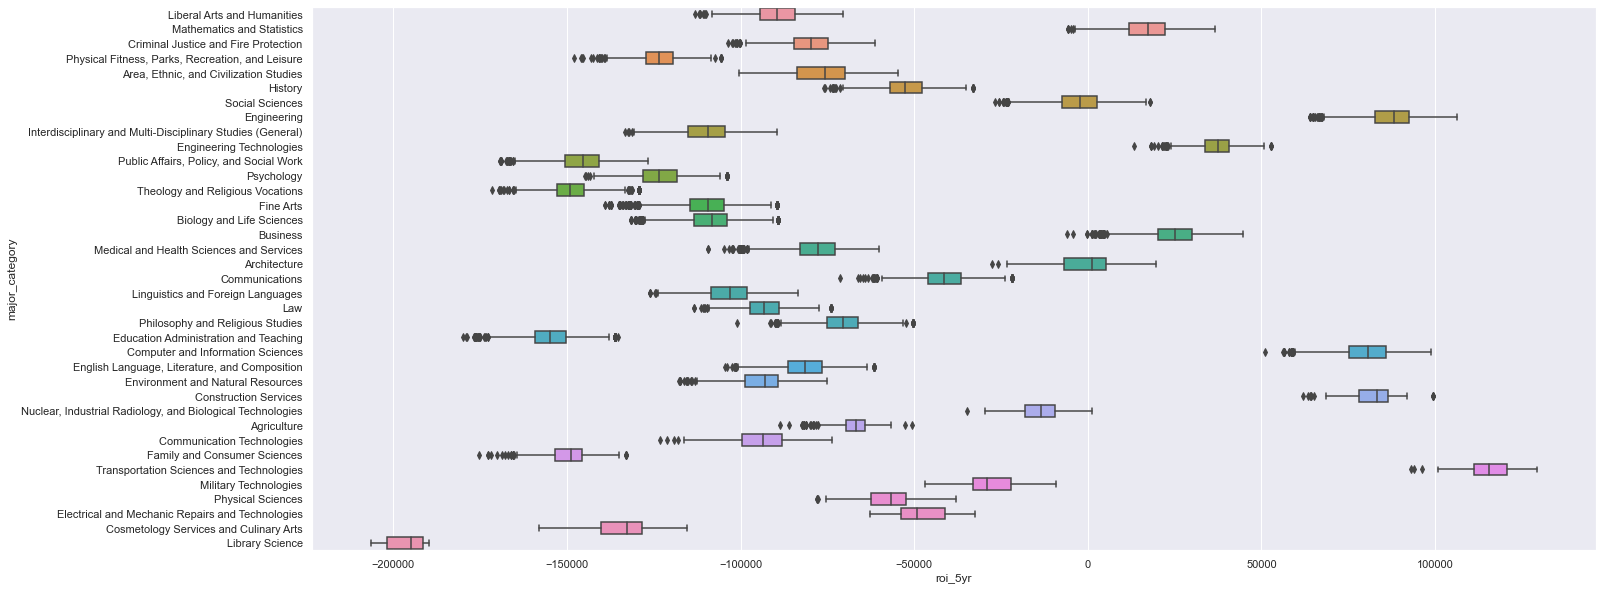

In [144]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='roi_5yr', data = train)

In [142]:
# top ten 5-year ROL avg majors
train.groupby('major_category').roi_5yr.mean().nlargest(10)

major_category
Transportation Sciences and Technologies                               114,910.45
Engineering                                                             86,934.09
Construction Services                                                   82,253.77
Computer and Information Sciences                                       80,552.22
Engineering Technologies                                                36,713.84
Business                                                                25,055.28
Mathematics and Statistics                                              16,558.85
Architecture                                                            -1,171.14
Social Sciences                                                         -2,570.25
Nuclear, Industrial Radiology, and Biological Technologies             -14,344.64
Name: roi_5yr, dtype: float64

<AxesSubplot:xlabel='roi_10yr', ylabel='major_category'>

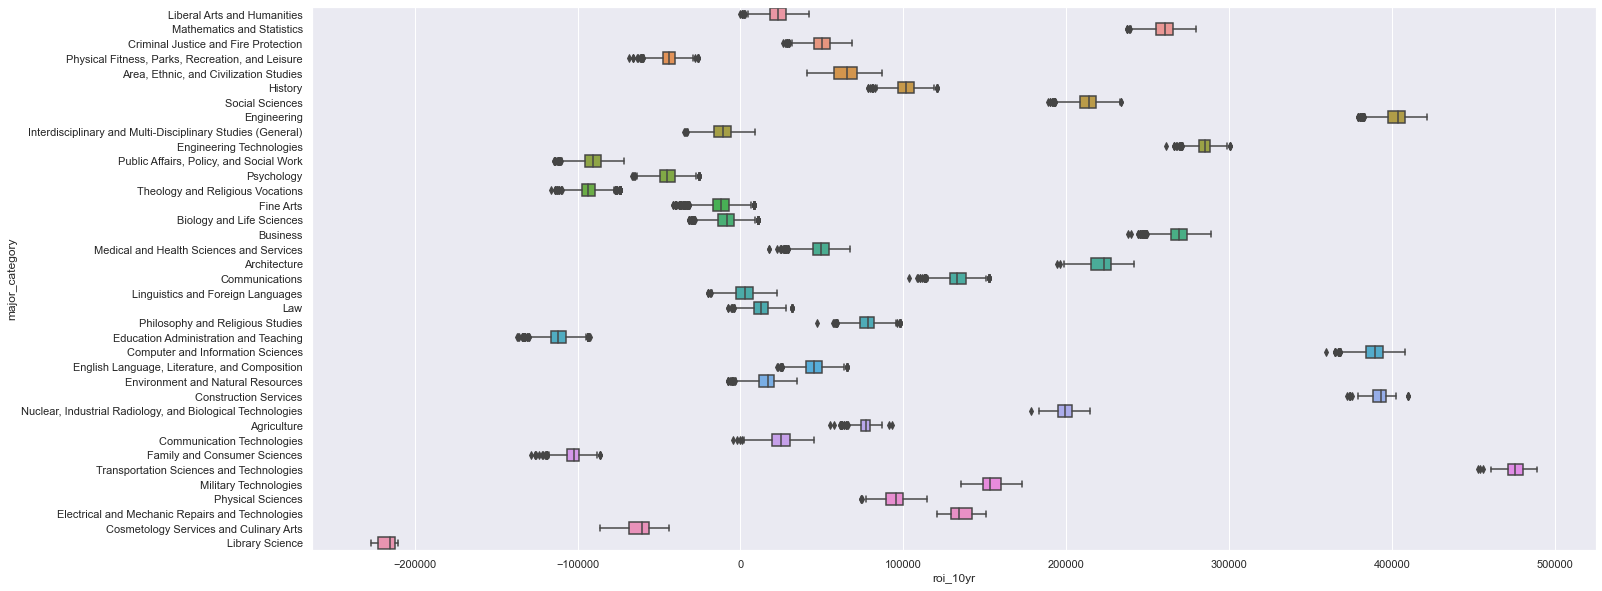

In [136]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='roi_10yr', data = train)

In [135]:
# top ten 10-year ROL avg majors
train.groupby('major_category').roi_10yr.mean().nlargest(10)

major_category
Transportation Sciences and Technologies                               474,881.69
Engineering                                                            402,389.57
Construction Services                                                  392,678.59
Computer and Information Sciences                                      389,534.19
Engineering Technologies                                               284,895.28
Business                                                               269,348.12
Mathematics and Statistics                                             259,969.27
Architecture                                                           221,039.26
Social Sciences                                                        213,435.14
Nuclear, Industrial Radiology, and Biological Technologies             198,836.16
Name: roi_10yr, dtype: float64

### 4. Admission rate by major
* impute null with total avg

In [2]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def train_iterative_imputer(train_df):
# using sklearn's iterative imputer to fill-in remaining nulls
        # placeholder for continuous features
        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        # dont learn from these variables
        target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total"
        ]
        
        num_lst = [col for col in l1 if col not in target_lst]
        
        # creating the "thing"
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)
        
        # fitting the "thing" and transforming it
        imputed = imputer.fit_transform(train_df[num_lst])

           # create a new dataframe with learned imputed data
        train_df_imputed = pd.DataFrame(imputed, index = train_df.index)

        # filling in missing values from learned imputer
        train_df[num_lst] = train_df_imputed

        # return the new imputed df
        return train_df

In [ ]:
train_impute = 

In [202]:
train.admission_rate.mean()

0.6632159688072748

In [299]:
train.groupby('major_category').admission_rate.mean()

major_category
Agriculture                                                                  0.69
Architecture                                                                 0.62
Area, Ethnic, and Civilization Studies                                       0.54
Biology and Life Sciences                                                    0.64
Business                                                                     0.69
Communication Technologies                                                   0.69
Communications                                                               0.69
Computer and Information Sciences                                            0.68
Construction Services                                                        0.71
Cosmetology Services and Culinary Arts                                       0.67
Criminal Justice and Fire Protection                                         0.69
Education Administration and Teaching                                        0.69
E

In [297]:
train[train.major_category == 'Business']['admission_rate'].isnull().sum()

0

In [278]:
# fill null with avg by major
train[train.major_category == 'Business']['admission_rate'].fillna(value = 0.69, inplace = True)

In [296]:
train.loc[(train.major_category == 'Business') & train.admission_rate.isna(), 'admission_rate'] = 0.69

In [298]:
# check null
train[train.admission_rate.isnull()].reset_index().major_category.value_counts()

Medical and Health Sciences and Services                      524
Computer and Information Sciences                             401
Education Administration and Teaching                         256
Fine Arts                                                     215
Criminal Justice and Fire Protection                          210
Public Affairs, Policy, and Social Work                       210
Social Sciences                                               182
Biology and Life Sciences                                     160
Theology and Religious Vocations                              113
Communications                                                 95
Liberal Arts and Humanities                                    81
Environment and Natural Resources                              76
English Language, Literature, and Composition                  75
Mathematics and Statistics                                     69
Psychology                                                     65
Physical F

<AxesSubplot:xlabel='admission_rate', ylabel='major_category'>

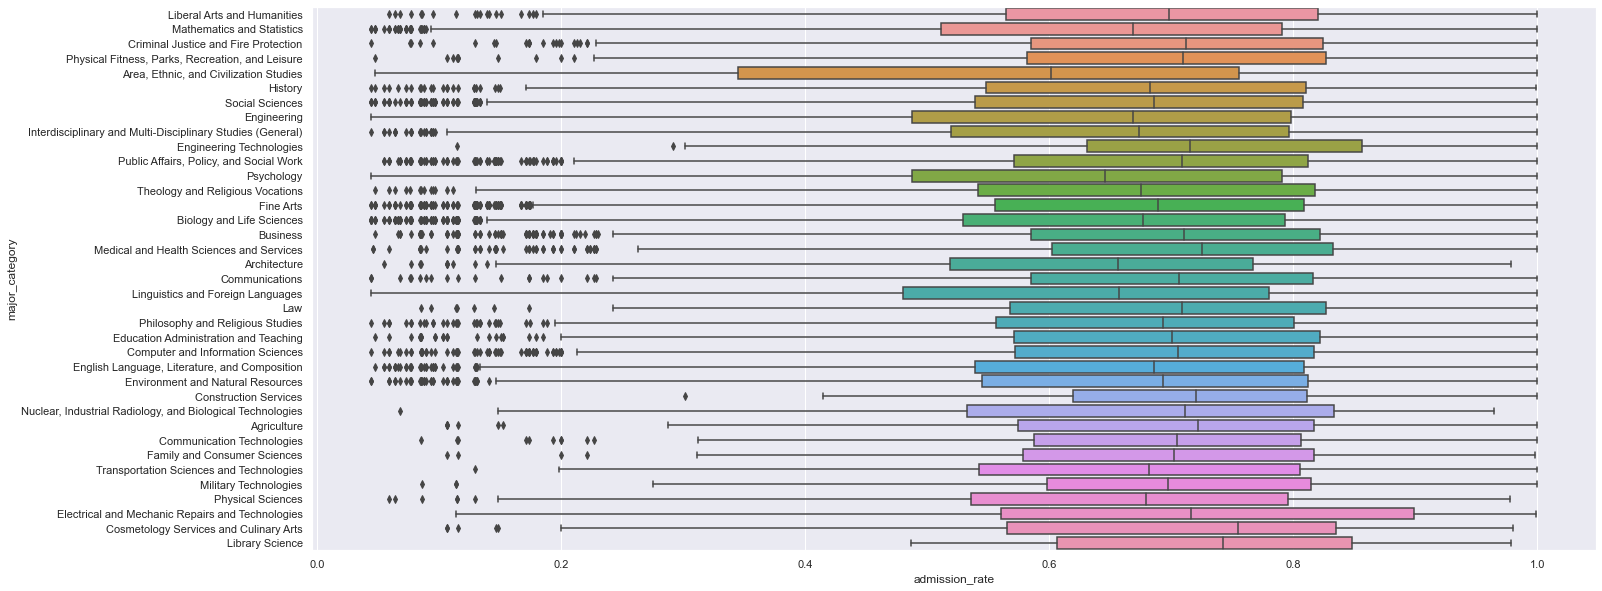

In [220]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='admission_rate', data = train)

<AxesSubplot:xlabel='admission_rate', ylabel='major_category'>

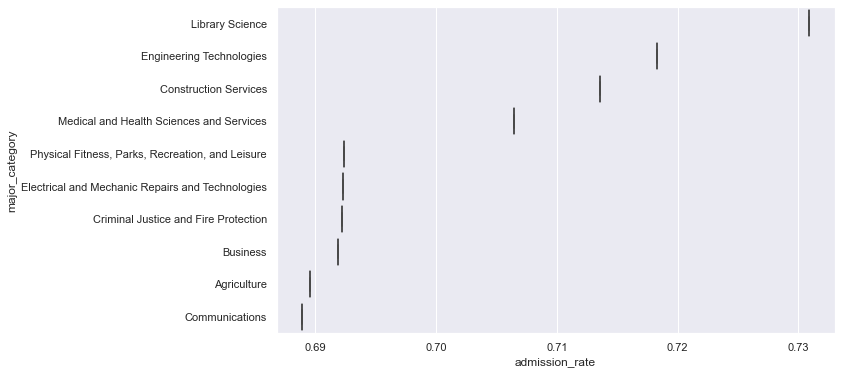

In [175]:
# top 10
plt.figure(figsize=(10, 6))
top10_admission_rate_major = train.groupby('major_category').admission_rate.mean().nlargest(10).reset_index()
sns.boxplot(y='major_category',x='admission_rate', data = top10_admission_rate_major)

### 5. avg sat score by major

<AxesSubplot:xlabel='avg_sat_admitted', ylabel='major_category'>

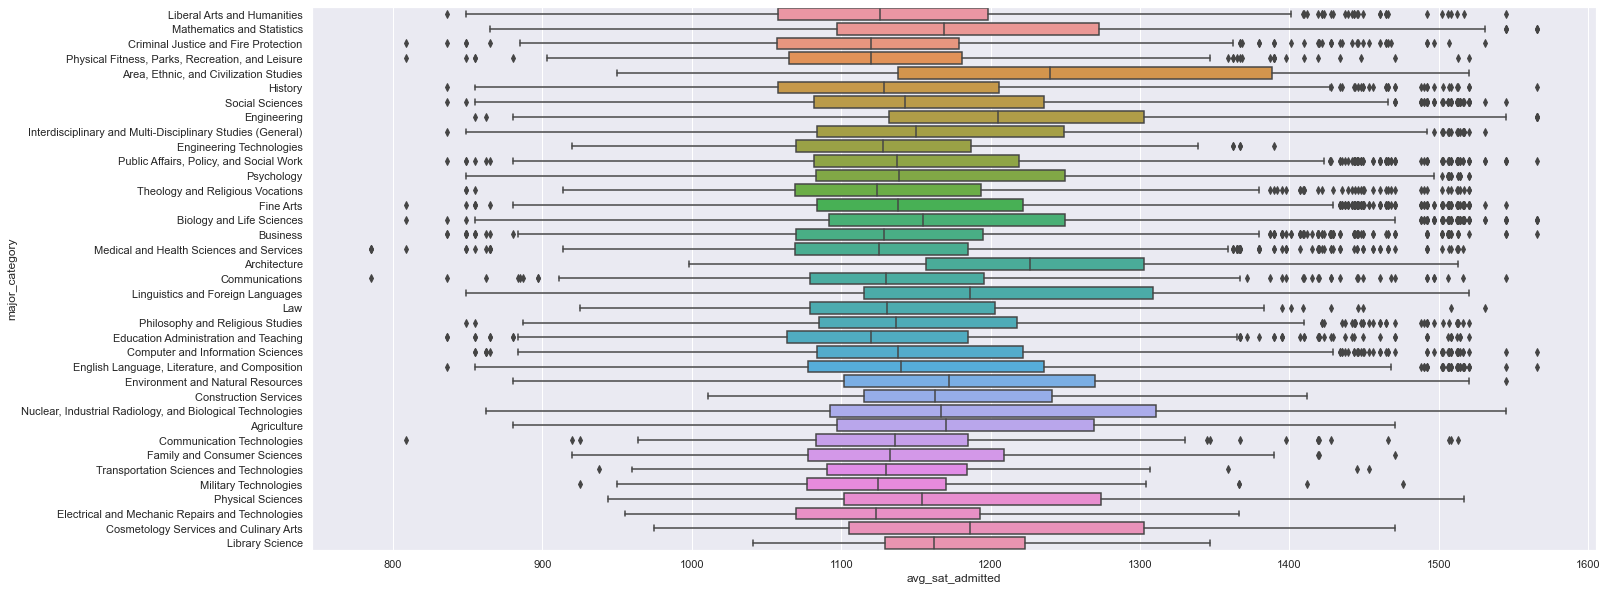

In [179]:
plt.figure(figsize=(23, 10))
sns.boxplot(y='major_category', x='avg_sat_admitted', data = train)

<AxesSubplot:xlabel='avg_sat_admitted', ylabel='major_category'>

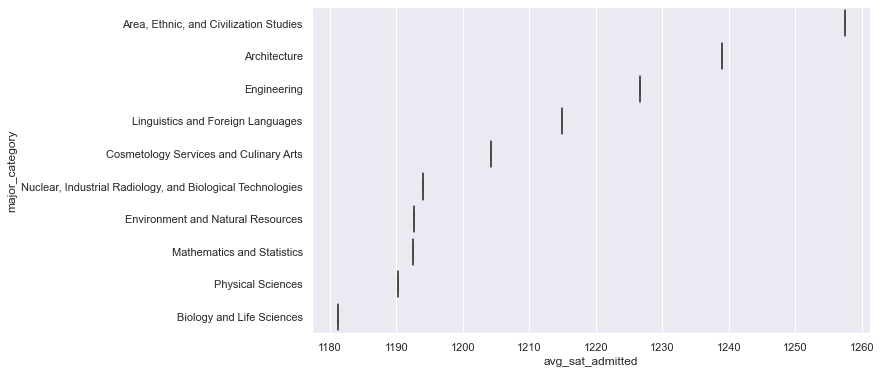

In [181]:
# top 10
plt.figure(figsize=(10, 6))
top10_sat_score_major = train.groupby('major_category').avg_sat_admitted.mean().nlargest(10).reset_index()
sns.boxplot(y='major_category',x='avg_sat_admitted', data = top10_sat_score_major)

### 6. full-time and part-time by major

'share_entering_students_first_ft', 'share_of_part_time'

In [182]:
train.groupby('major_category').share_entering_students_first_ft.mean().nlargest(10).reset_index()

,major_category,share_entering_students_first_ft
0,"Area, Ethnic, and Civilization Studies",0.78
1,Linguistics and Foreign Languages,0.77
2,Mathematics and Statistics,0.76
3,Engineering,0.75
4,Biology and Life Sciences,0.75
5,"English Language, Literature, and Composition",0.74
6,Library Science,0.74
7,Interdisciplinary and Multi-Disciplinary Studi...,0.74
8,Environment and Natural Resources,0.74
9,Philosophy and Religious Studies,0.73


In [183]:
train.groupby('major_category').share_of_part_time.mean().nlargest(10).reset_index()

,major_category,share_of_part_time
0,"Nuclear, Industrial Radiology, and Biological ...",0.22
1,Electrical and Mechanic Repairs and Technologies,0.22
2,Law,0.21
3,Transportation Sciences and Technologies,0.21
4,Construction Services,0.19
5,Criminal Justice and Fire Protection,0.19
6,Medical and Health Sciences and Services,0.19
7,Computer and Information Sciences,0.18
8,Engineering Technologies,0.18
9,Military Technologies,0.18


### 7. race by major
* impute null value as 0

        enrollment_share_asian
        enrollment_share_two_races
        enrollment_share_unknown
        enrollment_share_non_resident
        enrollment_share_pac_islander
        enrollment_share_hispanic
        enrollment_share_black
        enrollment_share_native_american
        enrollment_share_white

In [200]:
df['enrollment_share_asian'] = df['enrollment_share_asian'].fillna(0)
df['enrollment_share_two_races'] = df['enrollment_share_two_races'].fillna(0)
df['enrollment_share_unknown'] = df['enrollment_share_unknown'].fillna(0)
df['enrollment_share_non_resident'] = df['enrollment_share_non_resident'].fillna(0)
df['enrollment_share_pac_islander'] = df['enrollment_share_pac_islander'].fillna(0)
df['enrollment_share_hispanic'] = df['enrollment_share_hispanic'].fillna(0)
df['enrollment_share_black'] = df['enrollment_share_black'].fillna(0)
df['enrollment_share_native_american'] = df['enrollment_share_native_american'].fillna(0)
df['enrollment_share_white'] = df['enrollment_share_white'].fillna(0)

##  How is the 5 years and 10 years ROI in different states?

In [38]:
# plt.figure(figsize=(15, 7))
# sns.scatterplot(x='longitude', y='latitude', data=train, hue = 'roi_5yr')

<AxesSubplot:xlabel='state_post_code', ylabel='roi_5yr'>

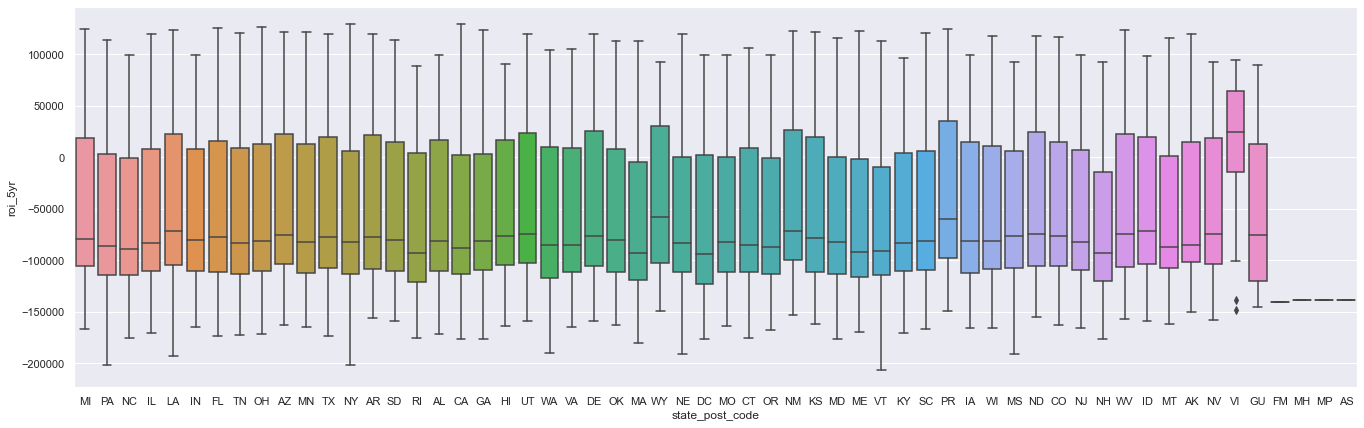

In [36]:
plt.figure(figsize=(23, 7))
sns.boxplot(x='state_post_code', y='roi_5yr', data = train)

<AxesSubplot:xlabel='state_post_code', ylabel='roi_10yr'>

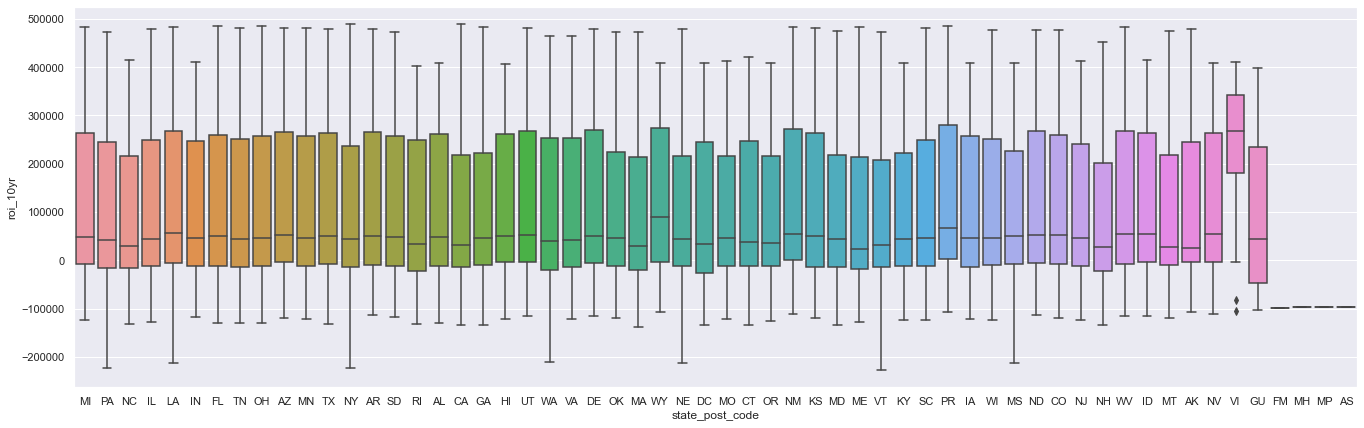

In [37]:
plt.figure(figsize=(23, 7))
sns.boxplot(x='state_post_code', y='roi_10yr', data = train)